使用四分位距和截距法进行异常值处理

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
ast_pre_false = pd.read_json('ast_pre_false.json')
ast_pre_true = pd.read_json('ast_pre_true.json')

astlevel_attribution_false = pd.read_json('astlevel_attribution_false.json')
astlevel_attribution_true = pd.read_json('astlevel_attribution_true.json')
astlevel_attribution_false['value'] = astlevel_attribution_false['value'] * 10
astlevel_attribution_true['value'] = astlevel_attribution_true['value'] * 10


In [3]:
len(ast_pre_false),len(astlevel_attribution_false)

(1011, 24630)

In [4]:
len(ast_pre_true),len(astlevel_attribution_true)

(2349, 71011)

true

In [5]:
def get_list_print_df(df, name):
    col_list = []
    for i in range(len(df)):
        if df.loc[i]['key'] == name:
            attr = df.loc[i]['value']
            col_list.append(attr)
    df = pd.DataFrame(col_list, columns=[name])
    return df

In [6]:
after_filter_name = ['MethodDeclaration','VariableDeclarator','StatementExpression','IfStatement',
                    'ForStatement','WhileStatement','TryStatement', 'ReturnStatement']

Not_delet_AST_token_type = ['FormalParameter','ClassReference', 'BasicType', 'InterfaceDeclaration',
                            'CatchClauseParameter', 'MethodInvocation', 'SuperMethodInvocation', 
                            'SuperMemberReference', 'ConstructorDeclaration', 'ReferenceType',
                            'MethodDeclaration', 'VariableDeclarator', 'IfStatement',
                            'WhileStatement', 'DoStatement', 'ForStatement', 'AssertStatement', 
                            'BreakStatement', 'ContinueStatement', 'ReturnStatement', 'ThrowStatement',
                            'SynchronizedStatement', 'TryStatement', 'SwitchStatement', 'BlockStatement', 
                            'StatementExpression', 'TryResource', 'CatchClause', 'CatchClauseParameter',
                            'SwitchStatementCase', 'ForControl', 'EnhancedForControl','BinaryOperation',
                            'UnaryOperation','TernaryExpression','SynchronizedStatement']


In [7]:
def get_clean_attribution(df,filter_list):
    for i in range(len(df)):
        if df.loc[i]['key'] not in filter_list:
            df = df.drop(index=i)
    df = df.reset_index(drop=True)
    return df

In [8]:
filter_astlevel_attribution_true = get_clean_attribution(astlevel_attribution_true,after_filter_name)
filter_astlevel_attribution_true.head()

key     value
0  MethodDeclaration -0.006580
1    ReturnStatement -0.005020
2  MethodDeclaration  0.542879
3    ReturnStatement  0.264125
4  MethodDeclaration  0.087545

In [9]:
def get_all_colunm_df(df,column_order):
    unique_values = df['key'].value_counts().index
    result = pd.DataFrame()

    for uniq in unique_values:
        attr = get_list_print_df(df, uniq)
        result = pd.concat([result, attr], axis=1)
        
    # 重新排序列名
    result = result[column_order]
    
    return result 

In [10]:
filter_astlevel_attribution_true_df = get_all_colunm_df(filter_astlevel_attribution_true,after_filter_name)
filter_astlevel_attribution_true_df.head()

MethodDeclaration  VariableDeclarator  StatementExpression  IfStatement  \
0          -0.006580            0.042800             0.137233     0.243033   
1           0.542879            0.948085             0.011839     0.054713   
2           0.087545            0.026383            -0.014333     0.029267   
3           0.041953           -0.024433            -0.000061     0.017851   
4           0.049525            0.000950            -0.000061     0.028088   

   ForStatement  WhileStatement  TryStatement  ReturnStatement  
0      0.022375        0.113625      0.359115        -0.005020  
1      0.035200        0.010764      0.297831         0.264125  
2      0.035200       -2.428344     -0.022173         0.332400  
3      0.121367        0.011725     -0.127756         0.072867  
4     -0.058325        0.242242     -0.010600         0.051300

In [11]:
std_value = filter_astlevel_attribution_true_df.std()
std_value

MethodDeclaration      0.418508
VariableDeclarator     0.237374
StatementExpression    0.213621
IfStatement            0.147854
ForStatement           0.149887
WhileStatement         0.336815
TryStatement           0.215099
ReturnStatement        0.381601
dtype: float64

In [12]:
# 画出和论文一样的图
def get_paper_picture(df, save_path=None):
    
    # 图形大小，随时改
    plt.figure(figsize=(40, 8))

    # 定义颜色
    palette = sns.color_palette('pastel')

    # 画图
    for i, col in enumerate(df.columns):
        # 小提琴
        sns.violinplot(x=np.full(len(df), i), y=df[col], inner=None, hue=np.full(len(df), i), palette=[palette[i]], legend=False)
        # 散点图
        sns.stripplot(x=np.full(len(df), i) - 0.5, y=df[col], color=palette[i], alpha=0.5, jitter=0.2, legend=False)
        # 箱线图
        sns.boxplot(x=np.full(len(df), i), y=df[col], width=0.2, showcaps=True, showfliers=False,  # 不显示异常值
                    boxprops=dict(facecolor='none', edgecolor='black', linewidth=1.5),  # 更改边框线条粗细
                    whiskerprops=dict(color='black', linewidth=2), 
                    capprops=dict(color='black', linewidth=2), 
                    medianprops=dict(color='#8B8B83', linewidth=2), 
                    flierprops=dict(marker='o', color='red', alpha=0.5))
    # 均值线
    mean_value = df.mean()
    print("均值 : ")
    print(mean_value)
    mean_value_sorted = mean_value.sort_values(ascending=False)
    print("\n从大到小排序后的均值 : ")
    print(mean_value_sorted)
    
    new_mean_value = [item for item in mean_value for _ in range(2)]
    for i in range(len(new_mean_value)):
        if i % 2 == 0:
            plt.plot([i - 0.5, i + 0.5], [new_mean_value[i], new_mean_value[i]], color='blue', linestyle='--', linewidth=2)
        else:
            plt.plot([i - 0.3, i + 0.3], [new_mean_value[i], new_mean_value[i]], color='blue', linestyle='--', linewidth=2)



    # 横坐标标签
    label_name = [item for sublist in [[x, f'{x}_num'] for x in df.columns] for item in sublist]
    ax = plt.gca()
    ax.set_xticks(np.arange(len(label_name)))  # 设置标签的位置
    ax.set_xticklabels(label_name)

    plt.ylabel('value')
        # 保存图像或显示
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"图像已保存为: {save_path}")
        
    plt.show()


均值 : 
MethodDeclaration      0.025818
VariableDeclarator     0.001787
StatementExpression   -0.004626
IfStatement            0.004117
ForStatement          -0.004633
WhileStatement        -0.009475
TryStatement           0.002136
ReturnStatement        0.001248
dtype: float64

从大到小排序后的均值 : 
MethodDeclaration      0.025818
IfStatement            0.004117
TryStatement           0.002136
VariableDeclarator     0.001787
ReturnStatement        0.001248
StatementExpression   -0.004626
ForStatement          -0.004633
WhileStatement        -0.009475
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/原始图片_true_before_Abs_ast.png


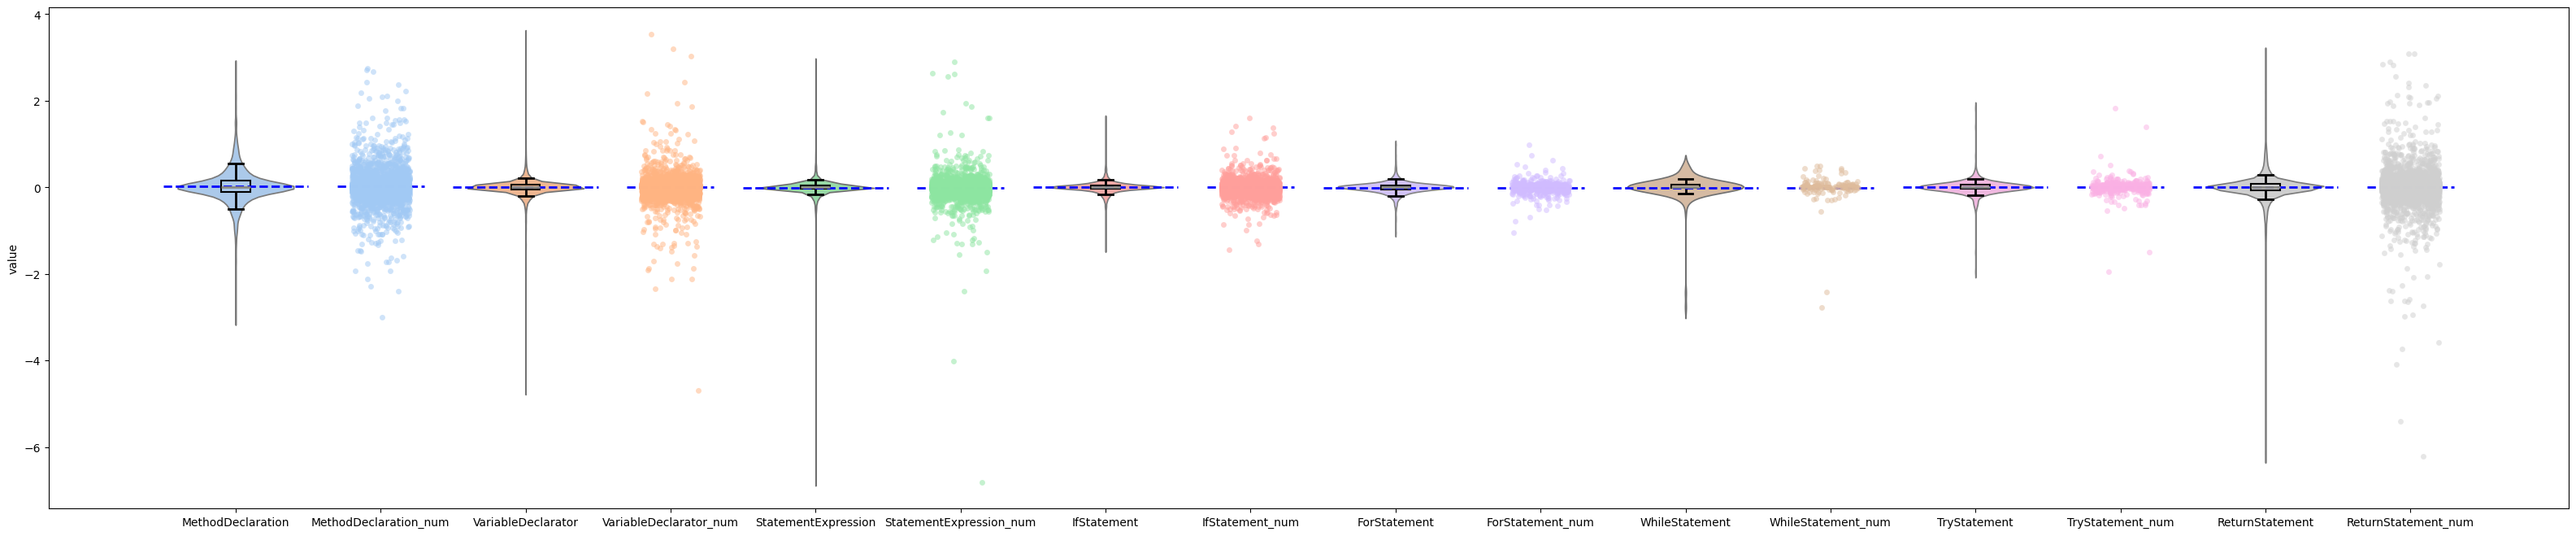

In [13]:
get_paper_picture(filter_astlevel_attribution_true_df,save_path='D:/BERT_learing/CCDP/picture/原始图片_true_before_Abs_ast.png')

In [14]:
filter_astlevel_attribution_true_df_abs = filter_astlevel_attribution_true_df.abs()
filter_astlevel_attribution_true_df_abs.head()

MethodDeclaration  VariableDeclarator  StatementExpression  IfStatement  \
0           0.006580            0.042800             0.137233     0.243033   
1           0.542879            0.948085             0.011839     0.054713   
2           0.087545            0.026383             0.014333     0.029267   
3           0.041953            0.024433             0.000061     0.017851   
4           0.049525            0.000950             0.000061     0.028088   

   ForStatement  WhileStatement  TryStatement  ReturnStatement  
0      0.022375        0.113625      0.359115         0.005020  
1      0.035200        0.010764      0.297831         0.264125  
2      0.035200        2.428344      0.022173         0.332400  
3      0.121367        0.011725      0.127756         0.072867  
4      0.058325        0.242242      0.010600         0.051300

均值 : 
MethodDeclaration      0.252673
VariableDeclarator     0.108795
StatementExpression    0.086522
IfStatement            0.081089
ForStatement           0.088587
WhileStatement         0.121879
TryStatement           0.095050
ReturnStatement        0.174157
dtype: float64

从大到小排序后的均值 : 
MethodDeclaration      0.252673
ReturnStatement        0.174157
WhileStatement         0.121879
VariableDeclarator     0.108795
TryStatement           0.095050
ForStatement           0.088587
StatementExpression    0.086522
IfStatement            0.081089
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/原始图片_true_Abs_ast.png


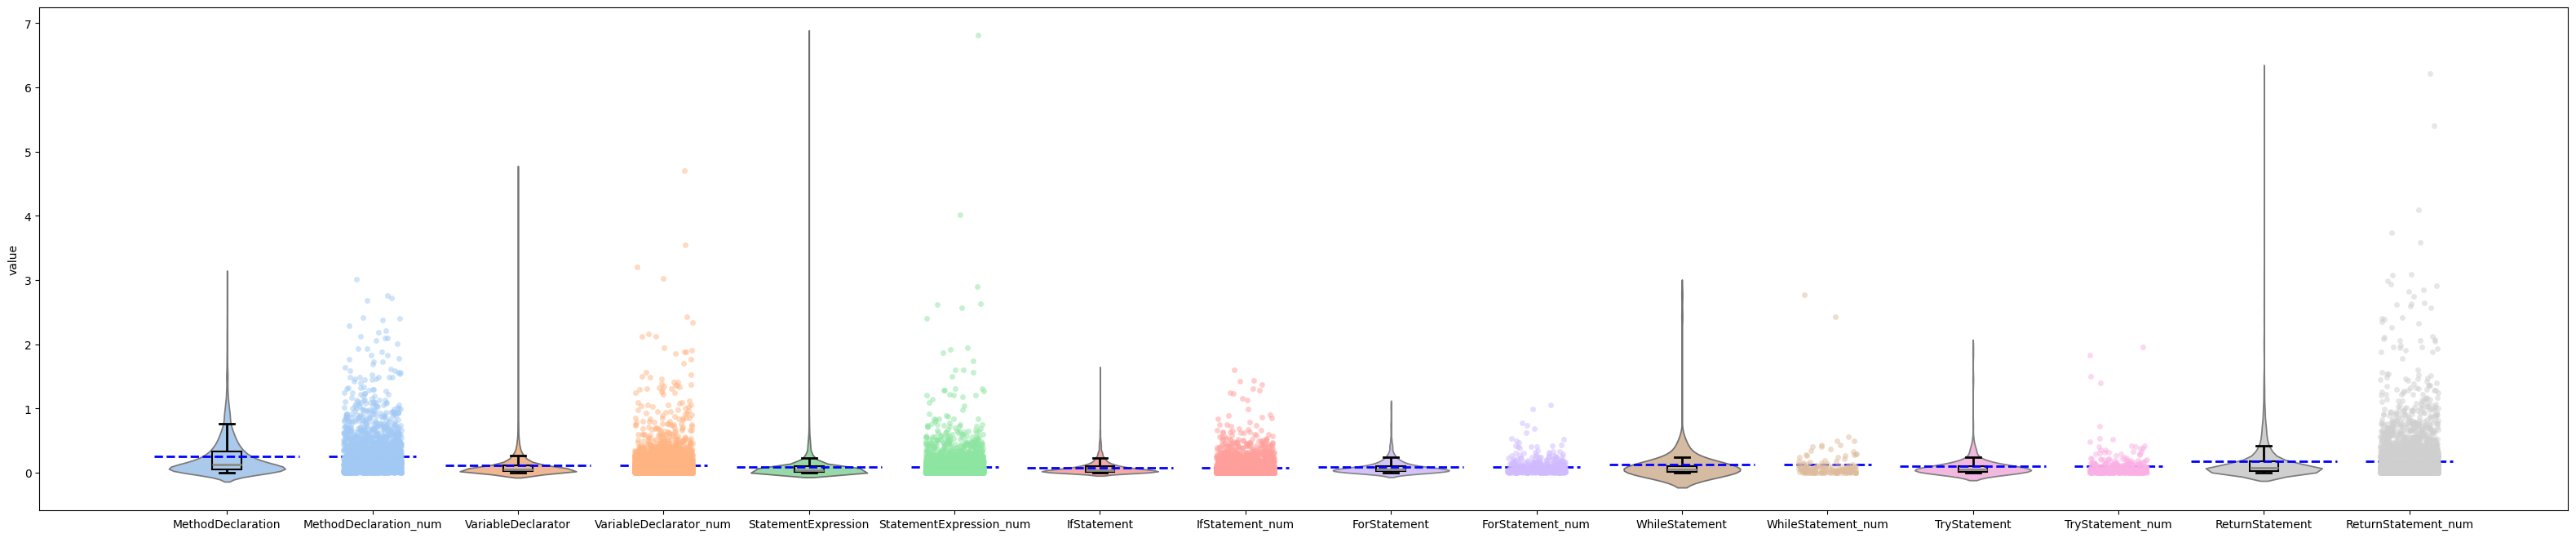

In [15]:
get_paper_picture(filter_astlevel_attribution_true_df_abs,save_path='D:/BERT_learing/CCDP/picture/原始图片_true_Abs_ast.png')

In [16]:
# 截尾处理

def Winsorization_outliers(df):
    total_nan_count_new = 0  # 初始化总共删除的数量

    for column_name in df.select_dtypes(include=[np.number]).columns:
        q1 = np.percentile(df[column_name].dropna(), 1)
        q3 = np.percentile(df[column_name].dropna(), 99)
        
        # 计算替换前的NaN数量
        nan_count_before = df[column_name].isna().sum()

        df[column_name] = df[column_name].apply(lambda x: np.nan if x < q1 or x > q3 else x)
        
        # 计算替换后的NaN数量
        nan_count_after = df[column_name].isna().sum()
        
        nan_count_new = nan_count_after - nan_count_before
               
        total_nan_count_new += nan_count_new    # 总共删除的数量
        
        print(f'列 {column_name} 的第1个分位数: {q1} \t第99个分位数: {q3}\t此列删除数量{nan_count_new}')
    print(f'所有列的总共删除的数量: {total_nan_count_new}')
    return df

true_for_Winsorization = filter_astlevel_attribution_true_df.copy()
true_Winsorization = Winsorization_outliers(true_for_Winsorization)

列 MethodDeclaration 的第1个分位数: -1.10600815048 	第99个分位数: 1.4524505676199997	此列删除数量50
列 VariableDeclarator 的第1个分位数: -0.69186033317 	第99个分位数: 0.6185833599400001	此列删除数量98
列 StatementExpression 的第1个分位数: -0.5201925000000001 	第99个分位数: 0.4723	此列删除数量95
列 IfStatement 的第1个分位数: -0.44292075552000004 	第99个分位数: 0.45230000000000004	此列删除数量72
列 ForStatement 的第1个分位数: -0.4302979514 	第99个分位数: 0.4352505795000008	此列删除数量10
列 WhileStatement 的第1个分位数: -1.5495906666400003 	第99个分位数: 0.46594550000000007	此列删除数量4
列 TryStatement 的第1个分位数: -0.4330830141 	第99个分位数: 0.4216201244000003	此列删除数量8
列 ReturnStatement 的第1个分位数: -1.1205224 	第99个分位数: 1.0879365000000107	此列删除数量86
所有列的总共删除的数量: 423


均值 : 
MethodDeclaration      0.023269
VariableDeclarator     0.002451
StatementExpression   -0.003124
IfStatement            0.003550
ForStatement          -0.004339
WhileStatement         0.019552
TryStatement           0.002153
ReturnStatement        0.003636
dtype: float64

从大到小排序后的均值 : 
MethodDeclaration      0.023269
WhileStatement         0.019552
ReturnStatement        0.003636
IfStatement            0.003550
VariableDeclarator     0.002451
TryStatement           0.002153
StatementExpression   -0.003124
ForStatement          -0.004339
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/Winsorization_true_before_Abs_ast.png


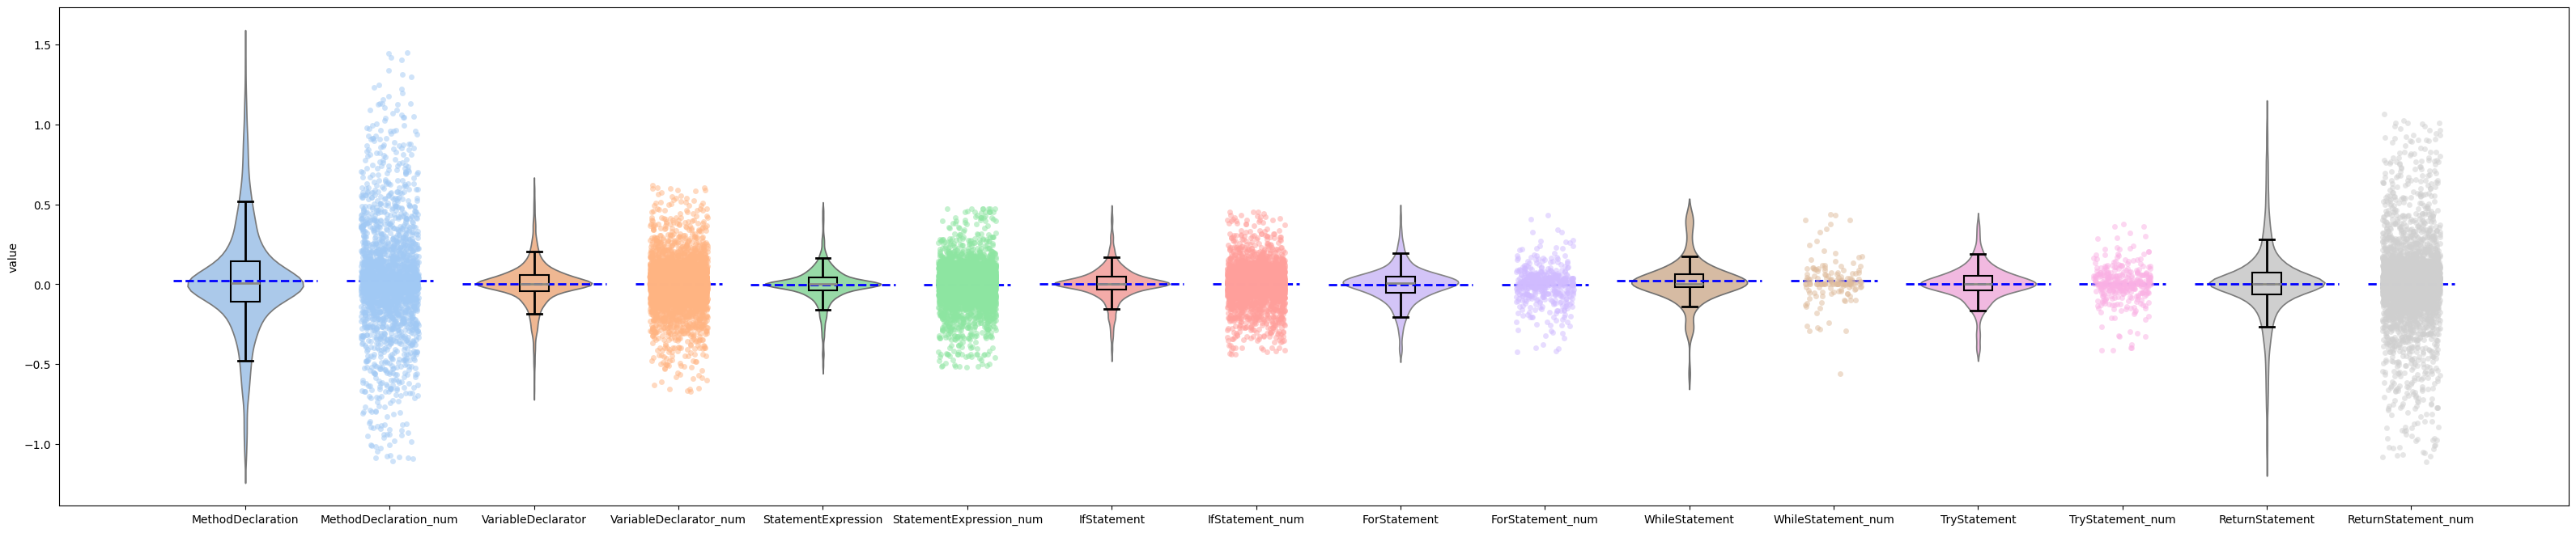

In [17]:
get_paper_picture(true_Winsorization,save_path='D:/BERT_learing/CCDP/picture/Winsorization_true_before_Abs_ast.png')

In [18]:
true_Winsorization_abs = true_Winsorization.abs()
true_Winsorization_abs.head()

MethodDeclaration  VariableDeclarator  StatementExpression  IfStatement  \
0           0.006580            0.042800             0.137233     0.243033   
1           0.542879                 NaN             0.011839     0.054713   
2           0.087545            0.026383             0.014333     0.029267   
3           0.041953            0.024433             0.000061     0.017851   
4           0.049525            0.000950             0.000061     0.028088   

   ForStatement  WhileStatement  TryStatement  ReturnStatement  
0      0.022375        0.113625      0.359115         0.005020  
1      0.035200        0.010764      0.297831         0.264125  
2      0.035200             NaN      0.022173         0.332400  
3      0.121367        0.011725      0.127756         0.072867  
4      0.058325        0.242242      0.010600         0.051300

均值 : 
MethodDeclaration      0.221508
VariableDeclarator     0.085940
StatementExpression    0.068357
IfStatement            0.068883
ForStatement           0.076149
WhileStatement         0.082282
TryStatement           0.072456
ReturnStatement        0.137738
dtype: float64

从大到小排序后的均值 : 
MethodDeclaration      0.221508
ReturnStatement        0.137738
VariableDeclarator     0.085940
WhileStatement         0.082282
ForStatement           0.076149
TryStatement           0.072456
IfStatement            0.068883
StatementExpression    0.068357
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/Winsorization_true_Abs_ast.png


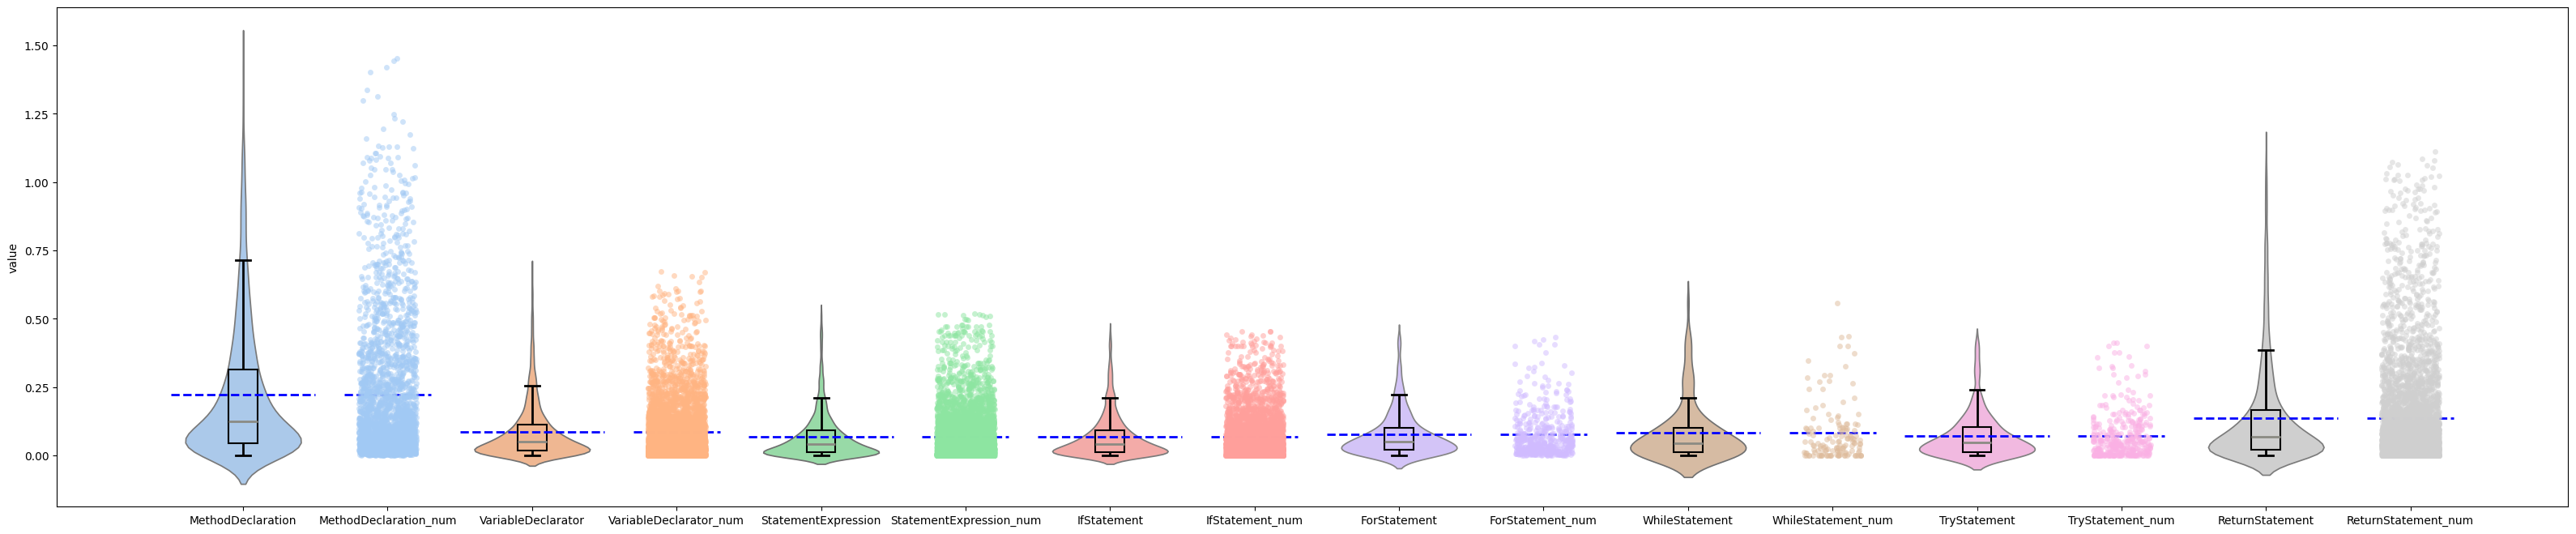

In [19]:
get_paper_picture(true_Winsorization_abs,save_path='D:/BERT_learing/CCDP/picture/Winsorization_true_Abs_ast.png')

列 MethodDeclaration 的第1个分位数: -0.5670911425999999 	第99个分位数: 0.6893334164999994	此列删除数量250
列 VariableDeclarator 的第1个分位数: -0.25439125014999997 	第99个分位数: 0.23268500000000014	此列删除数量486
列 StatementExpression 的第1个分位数: -0.21373513 	第99个分位数: 0.1730125	此列删除数量496
列 IfStatement 的第1个分位数: -0.2095891668 	第99个分位数: 0.18270036999999997	此列删除数量366
列 ForStatement 的第1个分位数: -0.21480937500000002 	第99个分位数: 0.1789184895	此列删除数量50
列 WhileStatement 的第1个分位数: -0.25669265625 	第99个分位数: 0.33949875000000007	此列删除数量16
列 TryStatement 的第1个分位数: -0.19375235305000002 	第99个分位数: 0.18906147030000006	此列删除数量38
列 ReturnStatement 的第1个分位数: -0.41991833319999994 	第99个分位数: 0.4271000001999998	此列删除数量424
所有列的总共删除的数量: 2126
均值 : 
MethodDeclaration      0.018660
VariableDeclarator     0.003252
StatementExpression   -0.001602
IfStatement            0.004073
ForStatement          -0.002873
WhileStatement         0.018114
TryStatement           0.004396
ReturnStatement        0.004252
dtype: float64

从大到小排序后的均值 : 
MethodDeclaration      0.018660
W

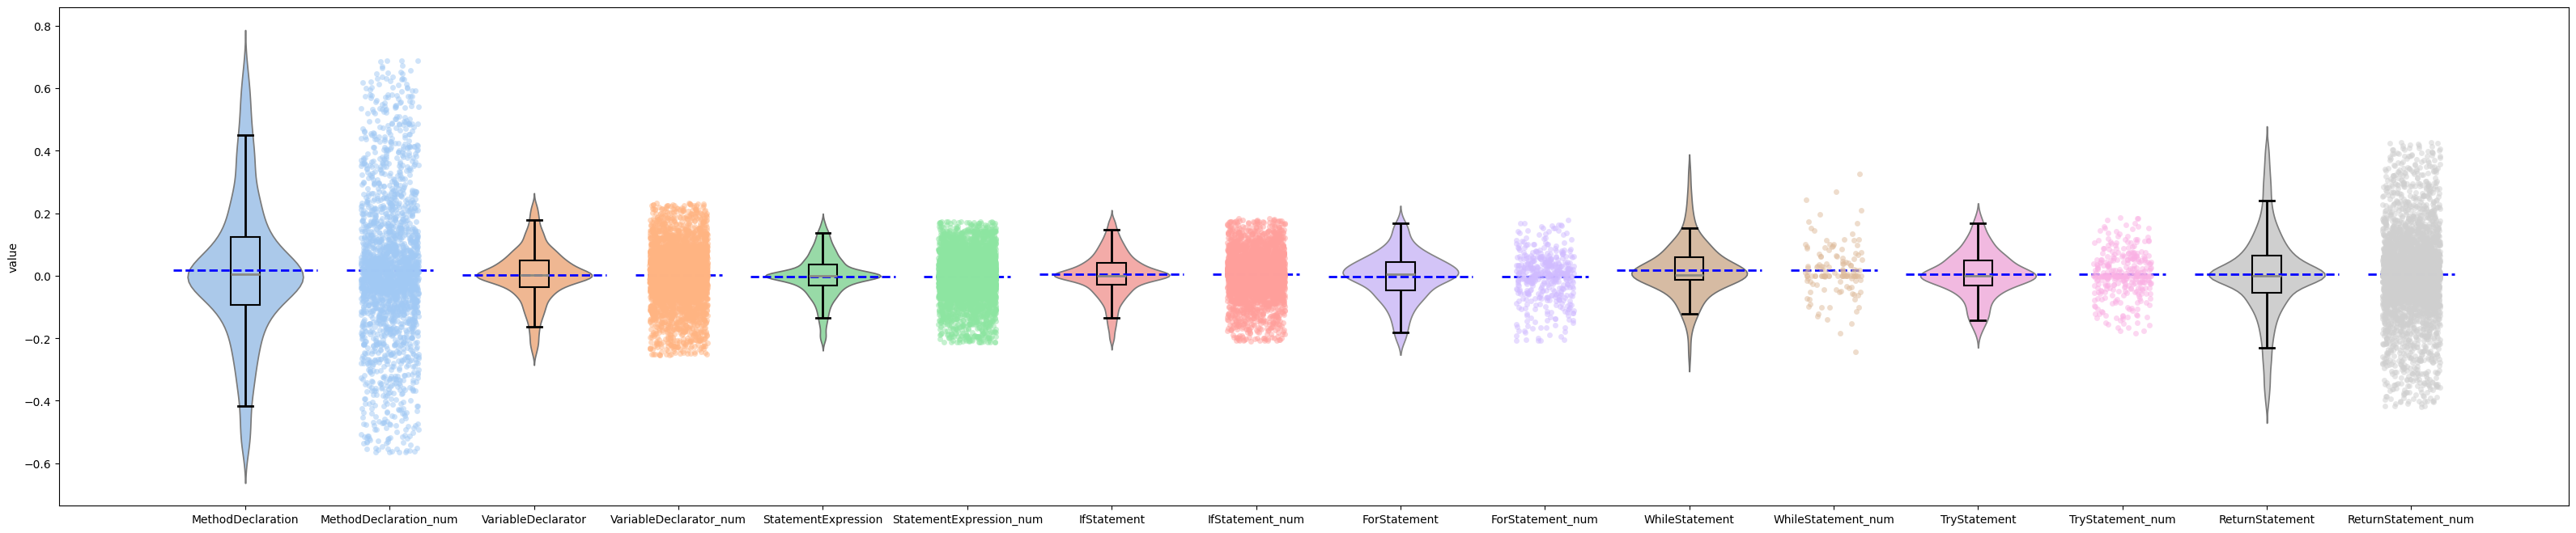

In [20]:
# 截尾处理 5%

def Winsorization_outliers_2(df):
    total_nan_count_new = 0  # 初始化总共删除的数量

    for column_name in df.select_dtypes(include=[np.number]).columns:
        q1 = np.percentile(df[column_name].dropna(), 5)
        q3 = np.percentile(df[column_name].dropna(), 95)
        
        # 计算替换前的NaN数量
        nan_count_before = df[column_name].isna().sum()

        df[column_name] = df[column_name].apply(lambda x: np.nan if x < q1 or x > q3 else x)
        
        # 计算替换后的NaN数量
        nan_count_after = df[column_name].isna().sum()
        
        nan_count_new = nan_count_after - nan_count_before
               
        total_nan_count_new += nan_count_new    # 总共删除的数量
        
        print(f'列 {column_name} 的第1个分位数: {q1} \t第99个分位数: {q3}\t此列删除数量{nan_count_new}')
    print(f'所有列的总共删除的数量: {total_nan_count_new}')
    return df

true_for_Winsorization_5 = filter_astlevel_attribution_true_df.copy()
true_Winsorization_5 = Winsorization_outliers_2(true_for_Winsorization_5)

get_paper_picture(true_Winsorization_5,save_path='D:/BERT_learing/CCDP/picture/Winsorization_5%_true_before_Abs_ast.png')

均值 : 
MethodDeclaration      0.165289
VariableDeclarator     0.061769
StatementExpression    0.048503
IfStatement            0.050138
ForStatement           0.057470
WhileStatement         0.056736
TryStatement           0.052727
ReturnStatement        0.091646
dtype: float64

从大到小排序后的均值 : 
MethodDeclaration      0.165289
ReturnStatement        0.091646
VariableDeclarator     0.061769
ForStatement           0.057470
WhileStatement         0.056736
TryStatement           0.052727
IfStatement            0.050138
StatementExpression    0.048503
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/Winsorization_5%_true_Abs_ast.png


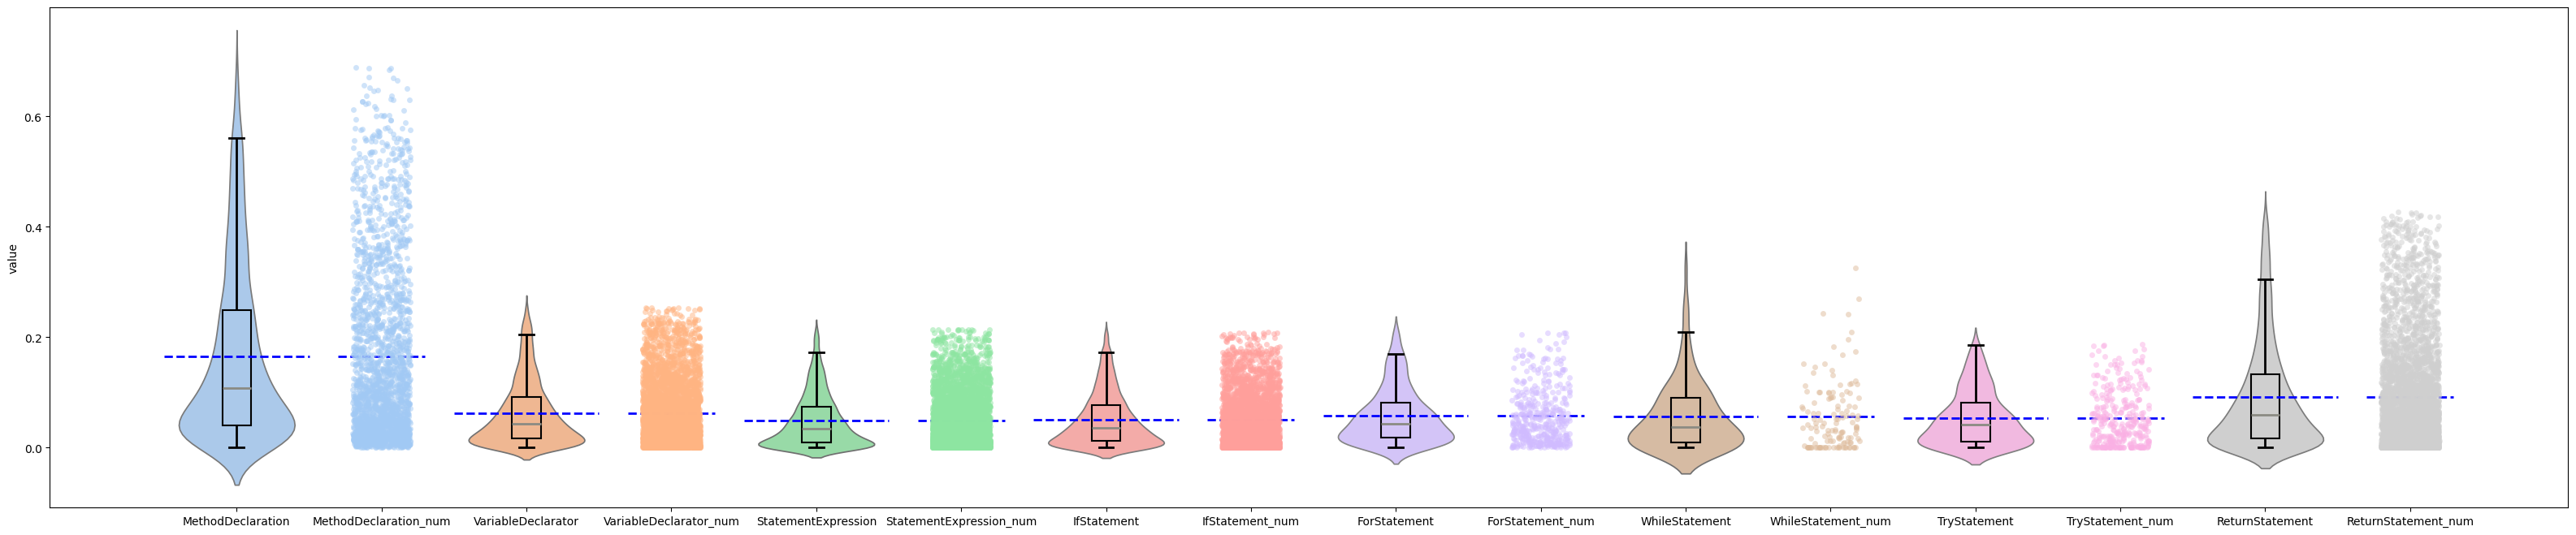

In [21]:
true_Winsorization_5_abs = true_Winsorization_5.abs()
get_paper_picture(true_Winsorization_5_abs,save_path='D:/BERT_learing/CCDP/picture/Winsorization_5%_true_Abs_ast.png')

In [22]:
# 四分位距法
def iqr_outliers(df):
    total_nan_count_new = 0  # 初始化总共删除的数量

    for column_name in df.select_dtypes(include=[np.number]).columns:
        q1 = df[column_name].quantile(0.25)
        q3 = df[column_name].quantile(0.75)
        iqr = q3 - q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        
        # 计算替换前的NaN数量
        nan_count_before = df[column_name].isna().sum()

        df[column_name] = df[column_name].apply(lambda x: np.nan if x < Lower_tail or x > Upper_tail else x)
        
        # 计算替换后的NaN数量
        nan_count_after = df[column_name].isna().sum()
        
        nan_count_new = nan_count_after - nan_count_before
               
        total_nan_count_new += nan_count_new    # 总共删除的数量
        print(f'下四分位数: {q1}, 上四分位数: {q3}, 最小值下界: {Lower_tail}, 最大值上界: {Upper_tail}\t此列删除数量{nan_count_new}')
    print(f'所有列的总共删除的数量: {total_nan_count_new}')
    return df

true_for_iqr = filter_astlevel_attribution_true_df.copy()
true_iqr = iqr_outliers(true_for_iqr)

下四分位数: -0.11318204400000001, 上四分位数: 0.1499766825, 最小值下界: -0.5079201337500001, 最大值上界: 0.5447147722500001	此列删除数量341
下四分位数: -0.04377500000000001, 上四分位数: 0.05767502925, 最小值下界: -0.19595004387500004, 最大值上界: 0.20985007312500004	此列删除数量645
下四分位数: -0.04005, 上四分位数: 0.042778125, 最小值下界: -0.16429218750000002, 最大值上界: 0.1670203125	此列删除数量632
下四分位数: -0.036000000000000004, 上四分位数: 0.048755556000000005, 最小值下界: -0.16313333400000002, 最大值上界: 0.17588889000000002	此列删除数量447
下四分位数: -0.056825, 上四分位数: 0.0502516925, 最小值下界: -0.21744003875, 最大值上界: 0.21086673125	此列删除数量46
下四分位数: -0.0207507815, 上四分位数: 0.06608124975, 最小值下界: -0.150998828375, 最大值上界: 0.19632929662499998	此列删除数量23
下四分位数: -0.03903158650000001, 上四分位数: 0.05302964625000001, 最小值下界: -0.17712343562500005, 最大值上界: 0.19112149537500003	此列删除数量38
下四分位数: -0.065491667, 上四分位数: 0.0769994, 最小值下界: -0.27922826749999996, 最大值上界: 0.2907360005	此列删除数量677
所有列的总共删除的数量: 2849


均值 : 
MethodDeclaration      0.012935
VariableDeclarator     0.007348
StatementExpression    0.002469
IfStatement            0.007966
ForStatement          -0.001183
WhileStatement         0.015383
TryStatement           0.005529
ReturnStatement        0.005194
dtype: float64

从大到小排序后的均值 : 
WhileStatement         0.015383
MethodDeclaration      0.012935
IfStatement            0.007966
VariableDeclarator     0.007348
TryStatement           0.005529
ReturnStatement        0.005194
StatementExpression    0.002469
ForStatement          -0.001183
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/iqr_true_before_Abs_ast.png


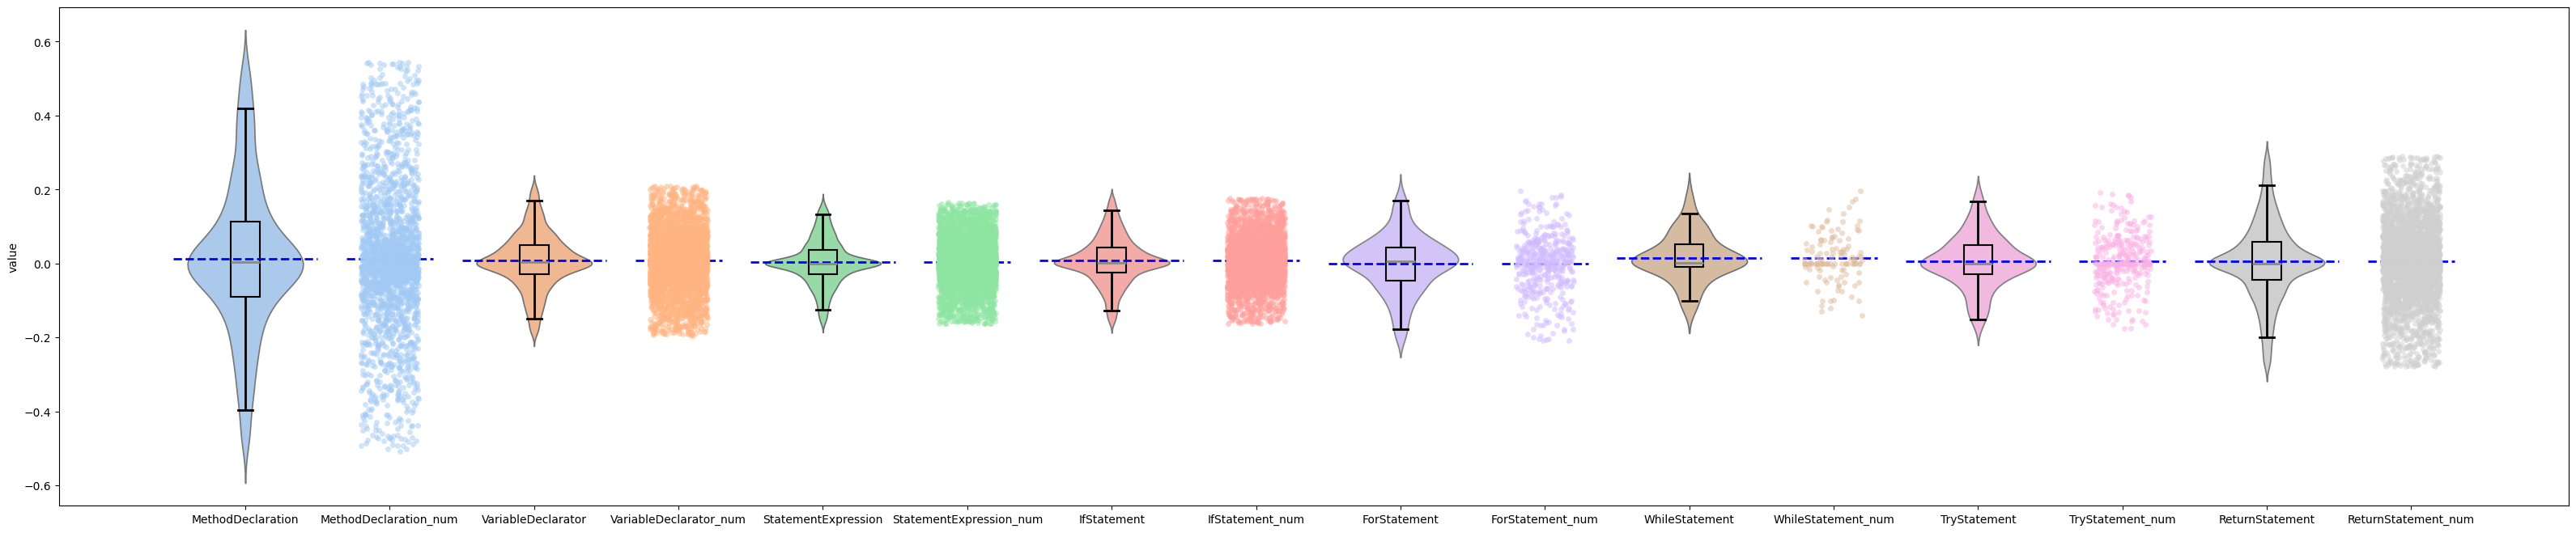

In [23]:
get_paper_picture(true_iqr,save_path='D:/BERT_learing/CCDP/picture/iqr_true_before_Abs_ast.png')

In [24]:
true_iqr_abs = true_iqr.abs()
true_iqr_abs.head()

MethodDeclaration  VariableDeclarator  StatementExpression  IfStatement  \
0           0.006580            0.042800             0.137233          NaN   
1           0.542879                 NaN             0.011839     0.054713   
2           0.087545            0.026383             0.014333     0.029267   
3           0.041953            0.024433             0.000061     0.017851   
4           0.049525            0.000950             0.000061     0.028088   

   ForStatement  WhileStatement  TryStatement  ReturnStatement  
0      0.022375        0.113625           NaN         0.005020  
1      0.035200        0.010764           NaN         0.264125  
2      0.035200             NaN      0.022173              NaN  
3      0.121367        0.011725      0.127756         0.072867  
4      0.058325             NaN      0.010600         0.051300

均值 : 
MethodDeclaration      0.147795
VariableDeclarator     0.055730
StatementExpression    0.044177
IfStatement            0.046721
ForStatement           0.058617
WhileStatement         0.046906
TryStatement           0.052745
ReturnStatement        0.073528
dtype: float64

从大到小排序后的均值 : 
MethodDeclaration      0.147795
ReturnStatement        0.073528
ForStatement           0.058617
VariableDeclarator     0.055730
TryStatement           0.052745
WhileStatement         0.046906
IfStatement            0.046721
StatementExpression    0.044177
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/iqr_true_Abs_ast.png


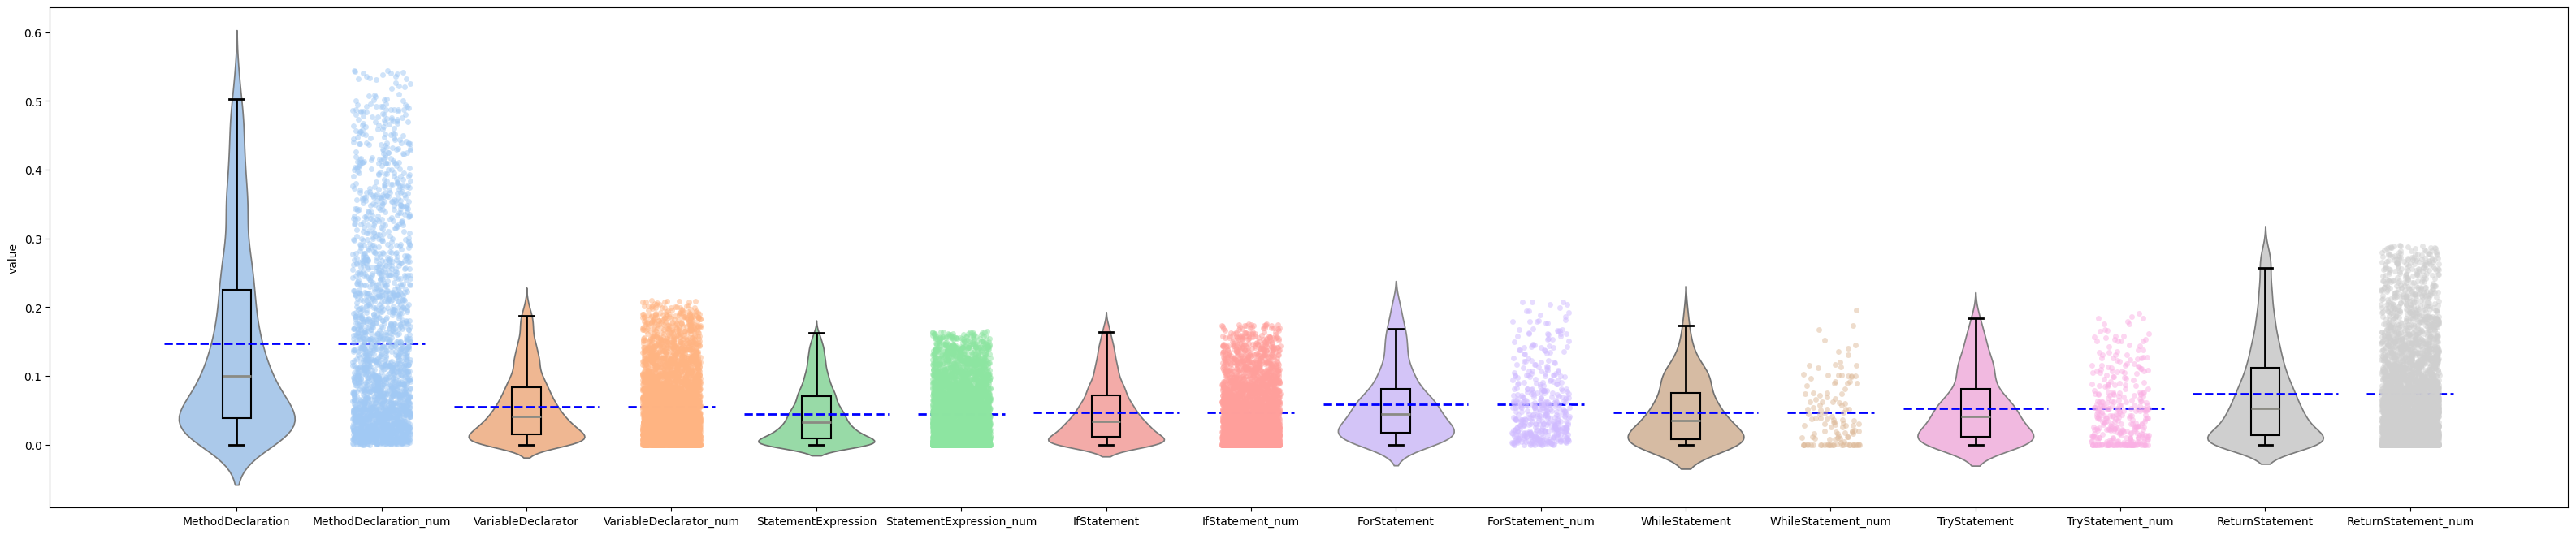

In [25]:
get_paper_picture(true_iqr_abs,save_path='D:/BERT_learing/CCDP/picture/iqr_true_Abs_ast.png')

false

In [26]:
filter_astlevel_attribution_false = get_clean_attribution(astlevel_attribution_false,after_filter_name)

In [27]:
filter_astlevel_attribution_false_df = get_all_colunm_df(filter_astlevel_attribution_false,after_filter_name)
filter_astlevel_attribution_false_df.head()

MethodDeclaration  VariableDeclarator  StatementExpression  IfStatement  \
0           0.024898           -0.716429            -0.047608    -0.106500   
1          -0.180215           -0.182800            -0.047608    -0.176867   
2          -0.759112           -0.334475            -0.134933    -0.051950   
3           0.388700            0.003300             0.000000     0.101210   
4           0.167360           -0.152411            -0.164550     0.144325   

   ForStatement  WhileStatement  TryStatement  ReturnStatement  
0     -0.101633        0.064745     -0.054336        -0.155400  
1      0.036594       -0.096238      0.091388        -0.061833  
2      0.000750        0.013096      0.210334        -0.291900  
3     -0.391250        0.031400      0.004875        -2.213250  
4      0.052839        0.046905     -0.013621        -1.186200

In [28]:
std_value = filter_astlevel_attribution_false_df.std()
std_value

MethodDeclaration      0.447654
VariableDeclarator     0.223055
StatementExpression    0.182925
IfStatement            0.147436
ForStatement           0.228907
WhileStatement         0.137382
TryStatement           0.158817
ReturnStatement        0.403301
dtype: float64

In [29]:
std_value = filter_astlevel_attribution_false_df.std()
std_value

MethodDeclaration      0.447654
VariableDeclarator     0.223055
StatementExpression    0.182925
IfStatement            0.147436
ForStatement           0.228907
WhileStatement         0.137382
TryStatement           0.158817
ReturnStatement        0.403301
dtype: float64

均值 : 
MethodDeclaration      0.007732
VariableDeclarator     0.000271
StatementExpression   -0.002475
IfStatement            0.006851
ForStatement          -0.000446
WhileStatement        -0.022661
TryStatement           0.045196
ReturnStatement       -0.007804
dtype: float64

从大到小排序后的均值 : 
TryStatement           0.045196
MethodDeclaration      0.007732
IfStatement            0.006851
VariableDeclarator     0.000271
ForStatement          -0.000446
StatementExpression   -0.002475
ReturnStatement       -0.007804
WhileStatement        -0.022661
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/原始图片_false_before_Abs_ast.png


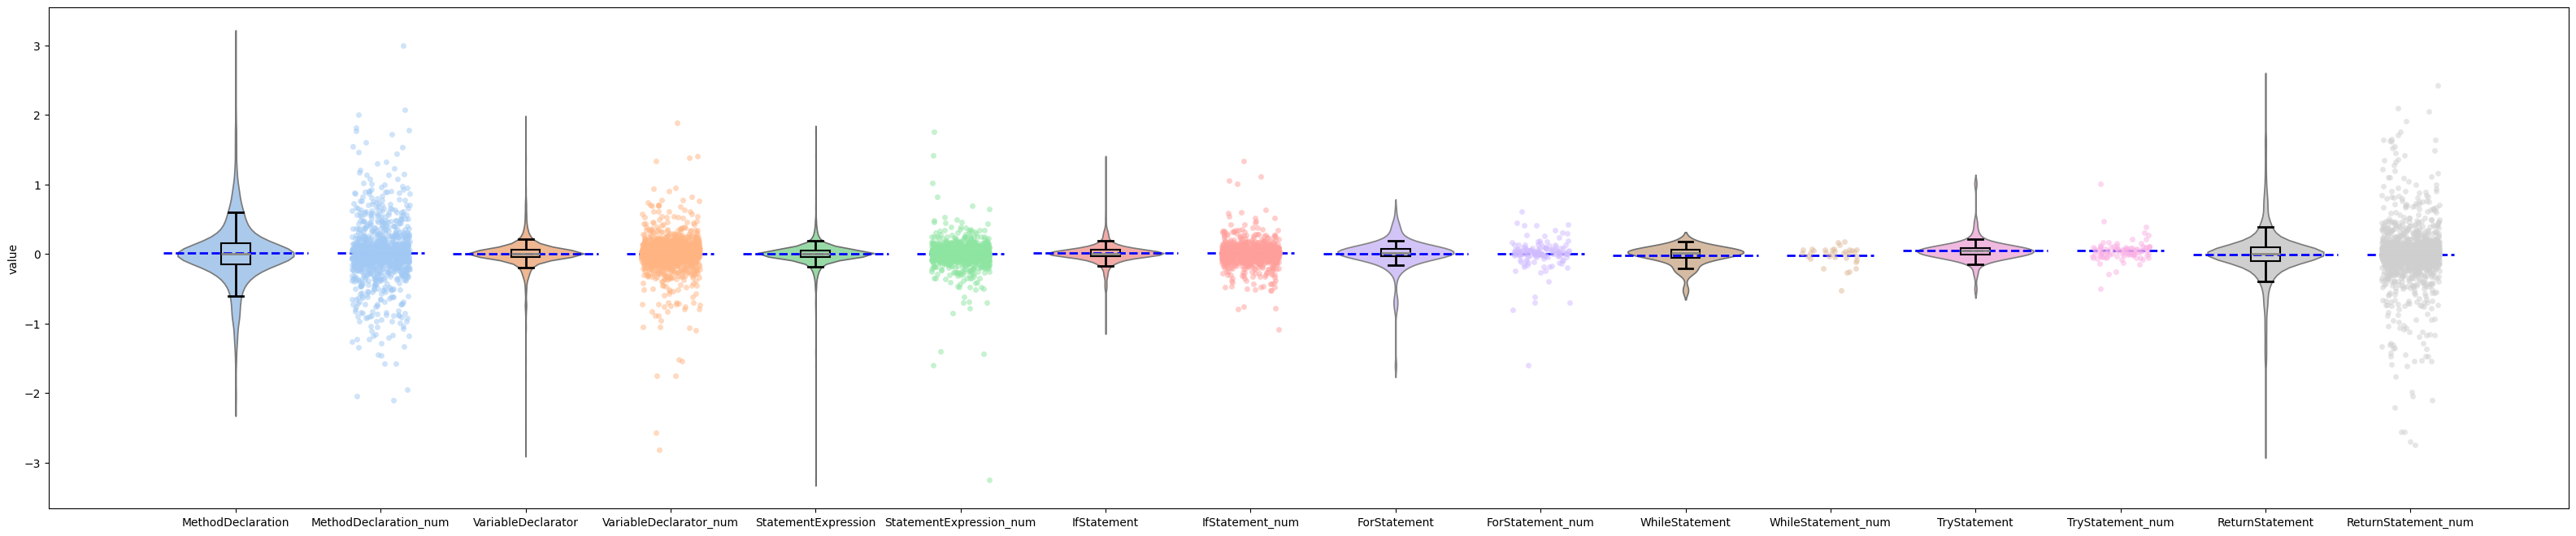

In [30]:
get_paper_picture(filter_astlevel_attribution_false_df,save_path='D:/BERT_learing/CCDP/picture/原始图片_false_before_Abs_ast.png')

In [31]:
filter_astlevel_attribution_false_df_abs = filter_astlevel_attribution_false_df.abs()
filter_astlevel_attribution_false_df_abs.head()

MethodDeclaration  VariableDeclarator  StatementExpression  IfStatement  \
0           0.024898            0.716429             0.047608     0.106500   
1           0.180215            0.182800             0.047608     0.176867   
2           0.759112            0.334475             0.134933     0.051950   
3           0.388700            0.003300             0.000000     0.101210   
4           0.167360            0.152411             0.164550     0.144325   

   ForStatement  WhileStatement  TryStatement  ReturnStatement  
0      0.101633        0.064745      0.054336         0.155400  
1      0.036594        0.096238      0.091388         0.061833  
2      0.000750        0.013096      0.210334         0.291900  
3      0.391250        0.031400      0.004875         2.213250  
4      0.052839        0.046905      0.013621         1.186200

均值 : 
MethodDeclaration      0.283174
VariableDeclarator     0.111276
StatementExpression    0.085702
IfStatement            0.084435
ForStatement           0.120108
WhileStatement         0.092024
TryStatement           0.095979
ReturnStatement        0.215287
dtype: float64

从大到小排序后的均值 : 
MethodDeclaration      0.283174
ReturnStatement        0.215287
ForStatement           0.120108
VariableDeclarator     0.111276
TryStatement           0.095979
WhileStatement         0.092024
StatementExpression    0.085702
IfStatement            0.084435
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/原始图片_false_Abs_ast.png


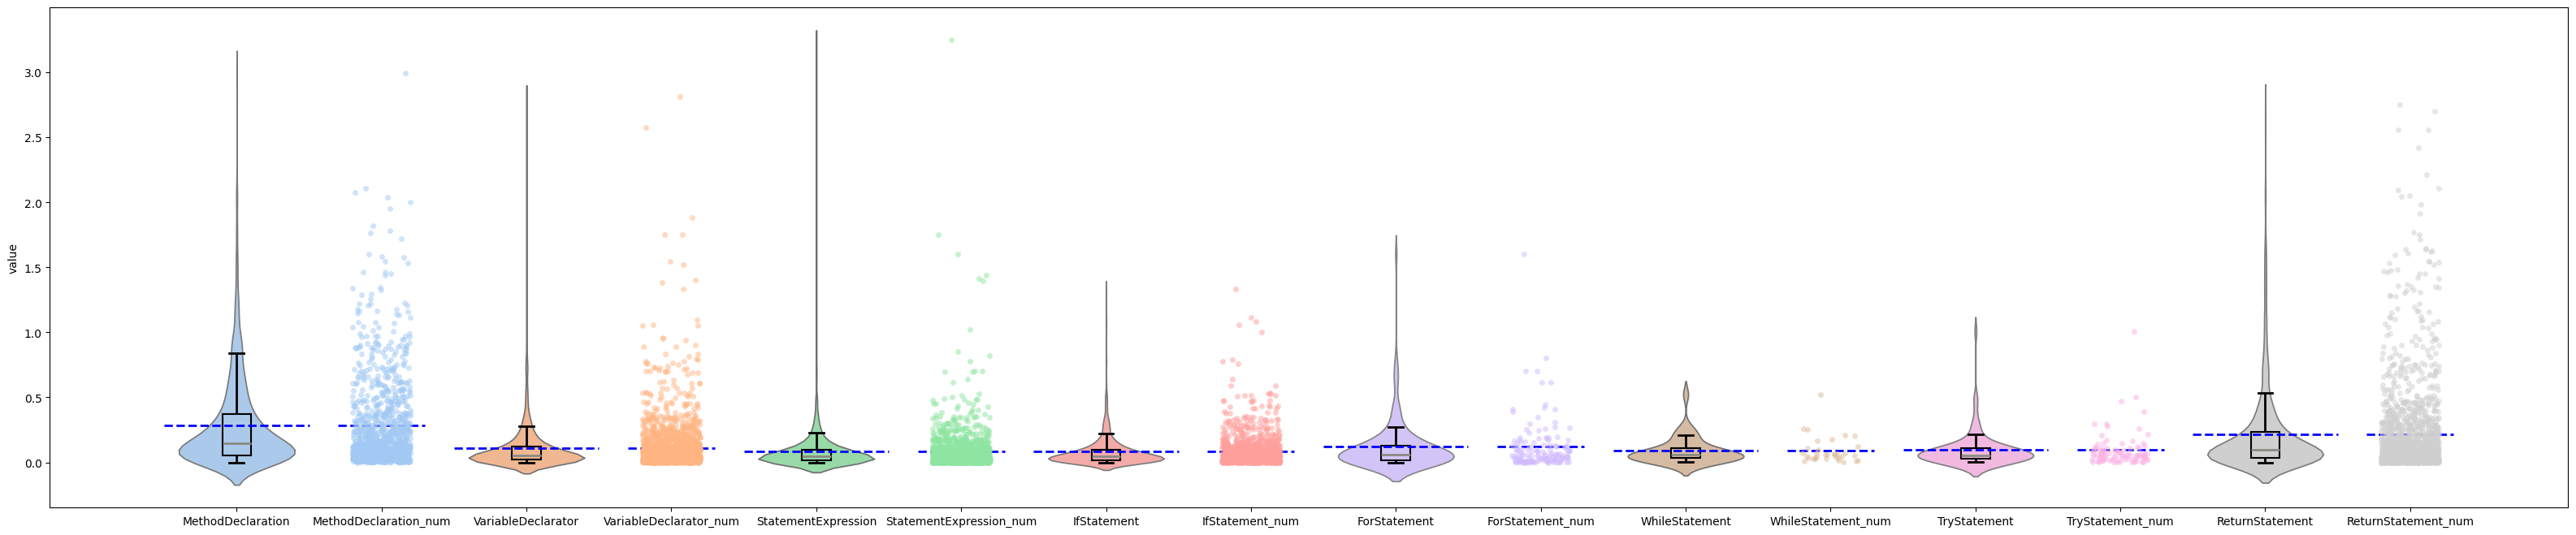

In [32]:
get_paper_picture(filter_astlevel_attribution_false_df_abs,save_path='D:/BERT_learing/CCDP/picture/原始图片_false_Abs_ast.png')

In [33]:
false_for_Winsorization = filter_astlevel_attribution_false_df.copy()
false_Winsorization = Winsorization_outliers(false_for_Winsorization)

列 MethodDeclaration 的第1个分位数: -1.239955 	第99个分位数: 1.4484821850400014	此列删除数量22
列 VariableDeclarator 的第1个分位数: -0.7546999999999999 	第99个分位数: 0.618330000000001	此列删除数量38
列 StatementExpression 的第1个分位数: -0.483366667 	第99个分位数: 0.38767333352	此列删除数量26
列 IfStatement 的第1个分位数: -0.46086740275000004 	第99个分位数: 0.426059583370001	此列删除数量26
列 ForStatement 的第1个分位数: -0.7647058330000001 	第99个分位数: 0.43452273459999985	此列删除数量4
列 WhileStatement 的第1个分位数: -0.43652837499999997 	第99个分位数: 0.17323251303	此列删除数量2
列 TryStatement 的第1个分位数: -0.3137855 	第99个分位数: 0.5173197222399991	此列删除数量2
列 ReturnStatement 的第1个分位数: -1.467651 	第99个分位数: 1.363169999999993	此列删除数量32
所有列的总共删除的数量: 152


均值 : 
MethodDeclaration      0.005097
VariableDeclarator     0.003673
StatementExpression   -0.000225
IfStatement            0.005836
ForStatement           0.009399
WhileStatement        -0.013281
TryStatement           0.040644
ReturnStatement       -0.005428
dtype: float64

从大到小排序后的均值 : 
TryStatement           0.040644
ForStatement           0.009399
IfStatement            0.005836
MethodDeclaration      0.005097
VariableDeclarator     0.003673
StatementExpression   -0.000225
ReturnStatement       -0.005428
WhileStatement        -0.013281
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/Winsorization_false_before_Abs_ast.png


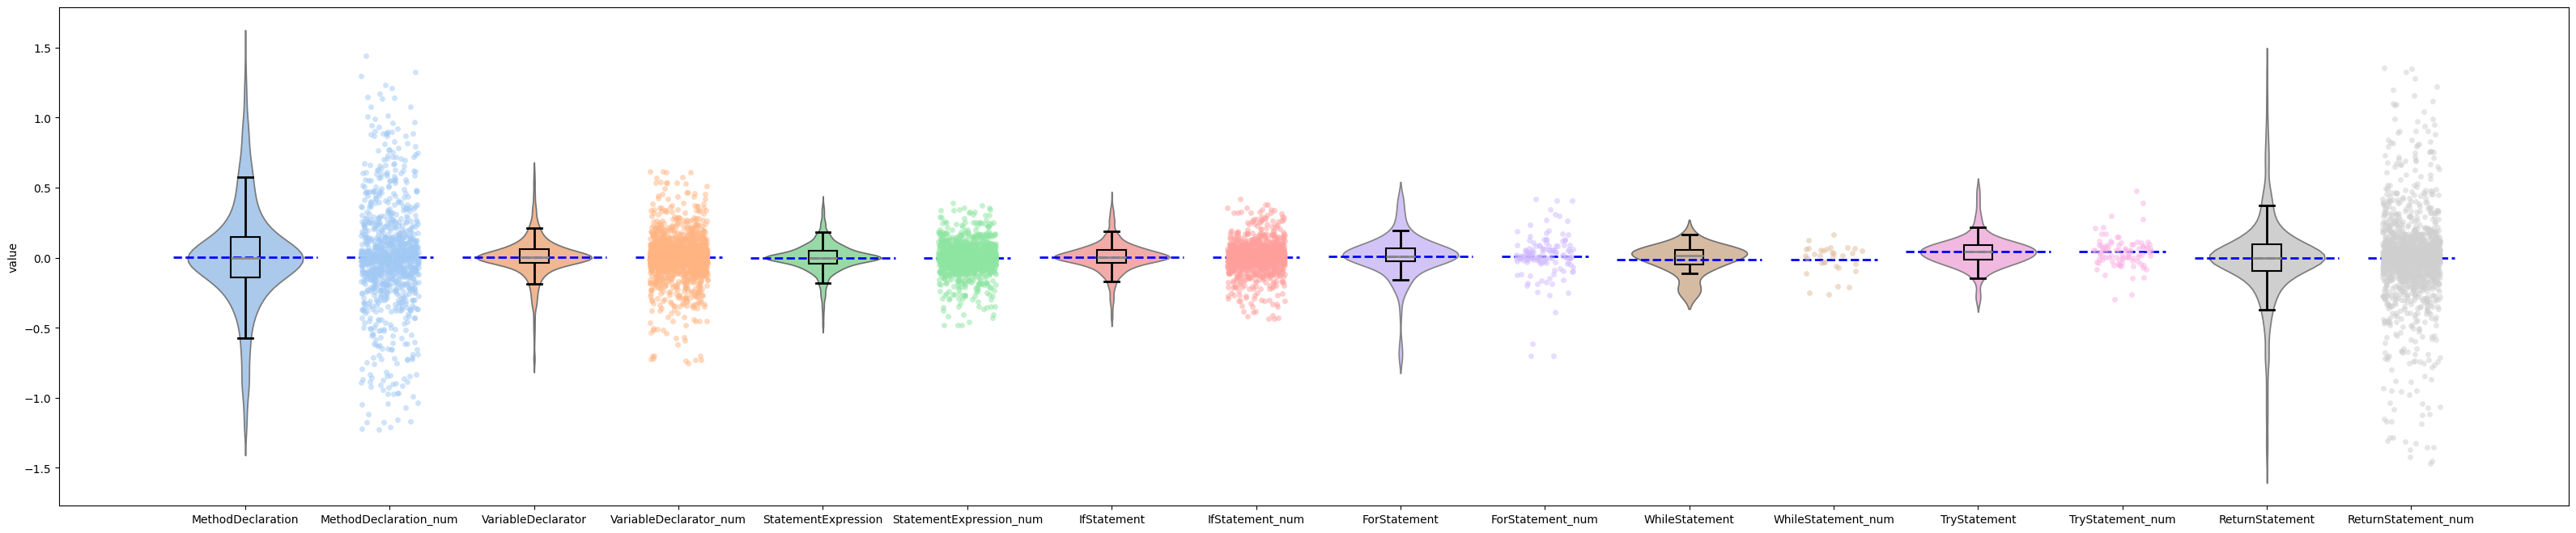

In [34]:
get_paper_picture(false_Winsorization,save_path='D:/BERT_learing/CCDP/picture/Winsorization_false_before_Abs_ast.png')

In [35]:
false_Winsorization_abs = false_Winsorization.abs()
false_Winsorization_abs.head()

MethodDeclaration  VariableDeclarator  StatementExpression  IfStatement  \
0           0.024898            0.716429             0.047608     0.106500   
1           0.180215            0.182800             0.047608     0.176867   
2           0.759112            0.334475             0.134933     0.051950   
3           0.388700            0.003300             0.000000     0.101210   
4           0.167360            0.152411             0.164550     0.144325   

   ForStatement  WhileStatement  TryStatement  ReturnStatement  
0      0.101633        0.064745      0.054336         0.155400  
1      0.036594        0.096238      0.091388         0.061833  
2      0.000750        0.013096      0.210334         0.291900  
3      0.391250        0.031400      0.004875              NaN  
4      0.052839        0.046905      0.013621         1.186200

均值 : 
MethodDeclaration      0.252755
VariableDeclarator     0.091213
StatementExpression    0.069894
IfStatement            0.071879
ForStatement           0.098311
WhileStatement         0.075931
TryStatement           0.081458
ReturnStatement        0.181811
dtype: float64

从大到小排序后的均值 : 
MethodDeclaration      0.252755
ReturnStatement        0.181811
ForStatement           0.098311
VariableDeclarator     0.091213
TryStatement           0.081458
WhileStatement         0.075931
IfStatement            0.071879
StatementExpression    0.069894
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/Winsorization_false_Abs_ast.png


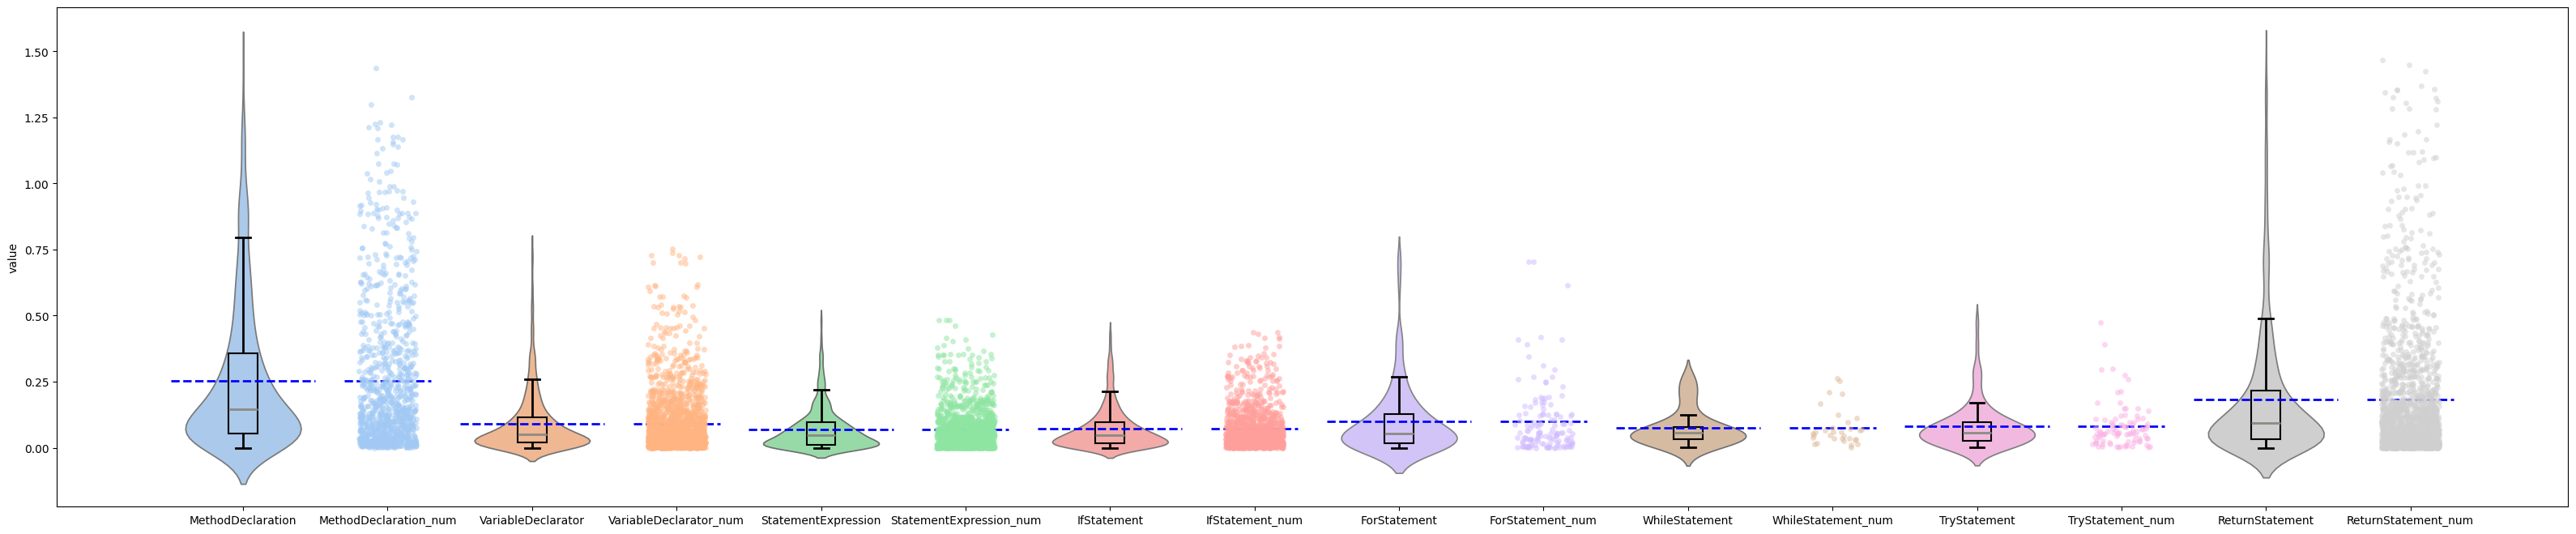

In [36]:
get_paper_picture(false_Winsorization_abs,save_path='D:/BERT_learing/CCDP/picture/Winsorization_false_Abs_ast.png')

列 MethodDeclaration 的第1个分位数: -0.7261370368000001 	第99个分位数: 0.7225675691999992	此列删除数量106
列 VariableDeclarator 的第1个分位数: -0.26770000000000005 	第99个分位数: 0.251025	此列删除数量187
列 StatementExpression 的第1个分位数: -0.19415333359999998 	第99个分位数: 0.17544740759999986	此列删除数量136
列 IfStatement 的第1个分位数: -0.19907820329999998 	第99个分位数: 0.1940678624000001	此列删除数量122
列 ForStatement 的第1个分位数: -0.25027499999999997 	第99个分位数: 0.295441667	此列删除数量14
列 WhileStatement 的第1个分位数: -0.25652375 	第99个分位数: 0.13931531684999993	此列删除数量4
列 TryStatement 的第1个分位数: -0.1316375004 	第99个分位数: 0.23863833339999949	此列删除数量10
列 ReturnStatement 的第1个分位数: -0.557995 	第99个分位数: 0.5007843749999985	此列删除数量160
所有列的总共删除的数量: 739
均值 : 
MethodDeclaration      0.005377
VariableDeclarator     0.005490
StatementExpression    0.002118
IfStatement            0.006749
ForStatement           0.016354
WhileStatement        -0.010951
TryStatement           0.037424
ReturnStatement       -0.002192
dtype: float64

从大到小排序后的均值 : 
TryStatement           0.037424
ForStatemen

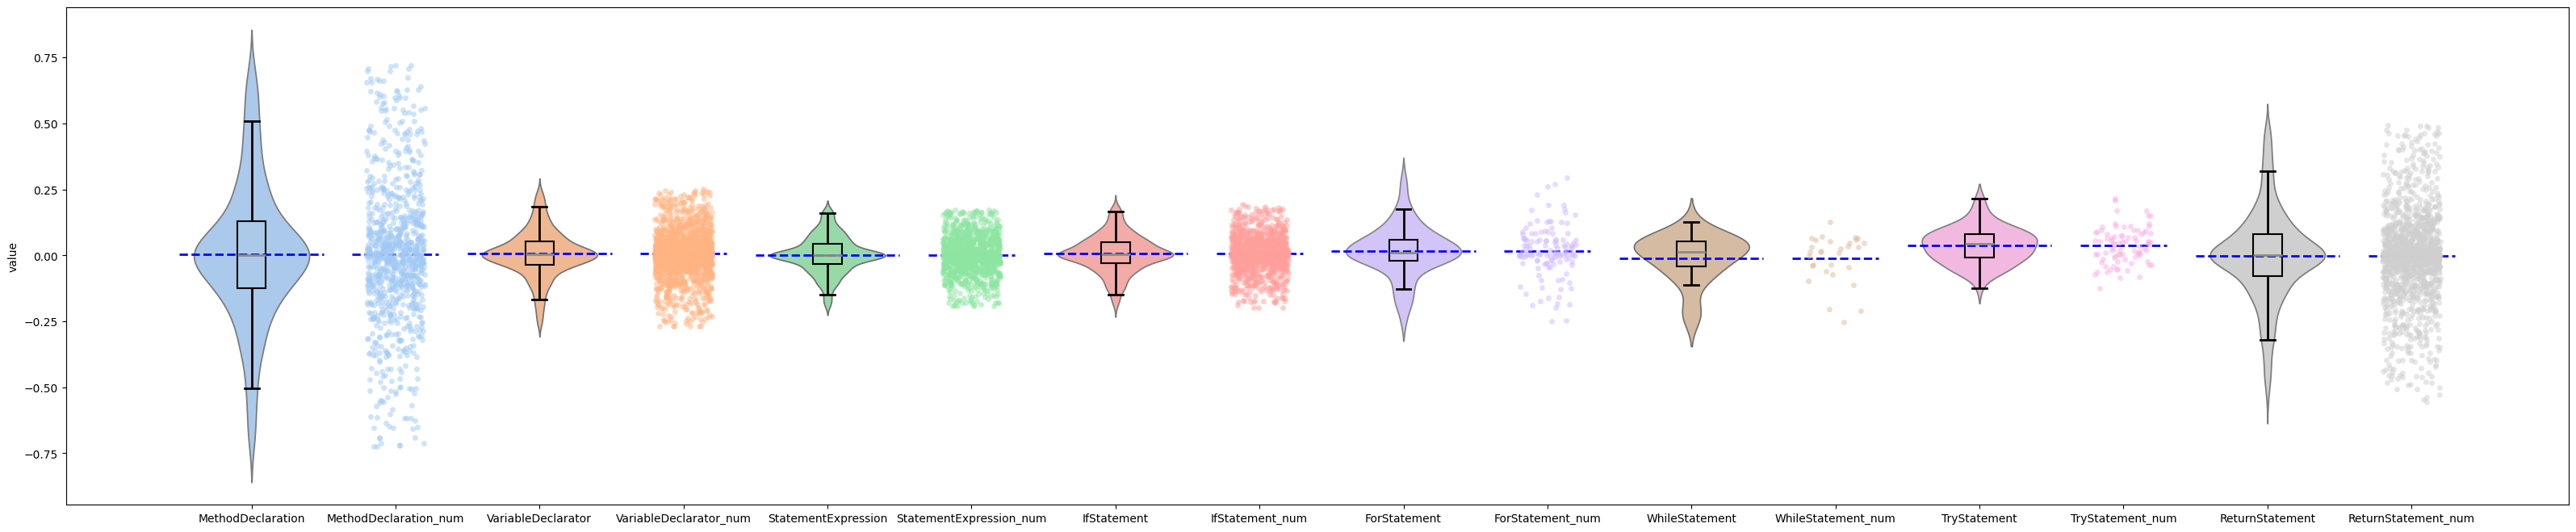

In [37]:
false_for_Winsorization_5 = filter_astlevel_attribution_false_df.copy()
false_Winsorization_5 = Winsorization_outliers_2(false_for_Winsorization_5)

get_paper_picture(false_Winsorization_5,save_path='D:/BERT_learing/CCDP/picture/Winsorization_5%_false_before_Abs_ast.png')

均值 : 
MethodDeclaration      0.191111
VariableDeclarator     0.064367
StatementExpression    0.051312
IfStatement            0.053266
ForStatement           0.070050
WhileStatement         0.066708
TryStatement           0.061756
ReturnStatement        0.121035
dtype: float64

从大到小排序后的均值 : 
MethodDeclaration      0.191111
ReturnStatement        0.121035
ForStatement           0.070050
WhileStatement         0.066708
VariableDeclarator     0.064367
TryStatement           0.061756
IfStatement            0.053266
StatementExpression    0.051312
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/Winsorization_5%_false_Abs_ast.png


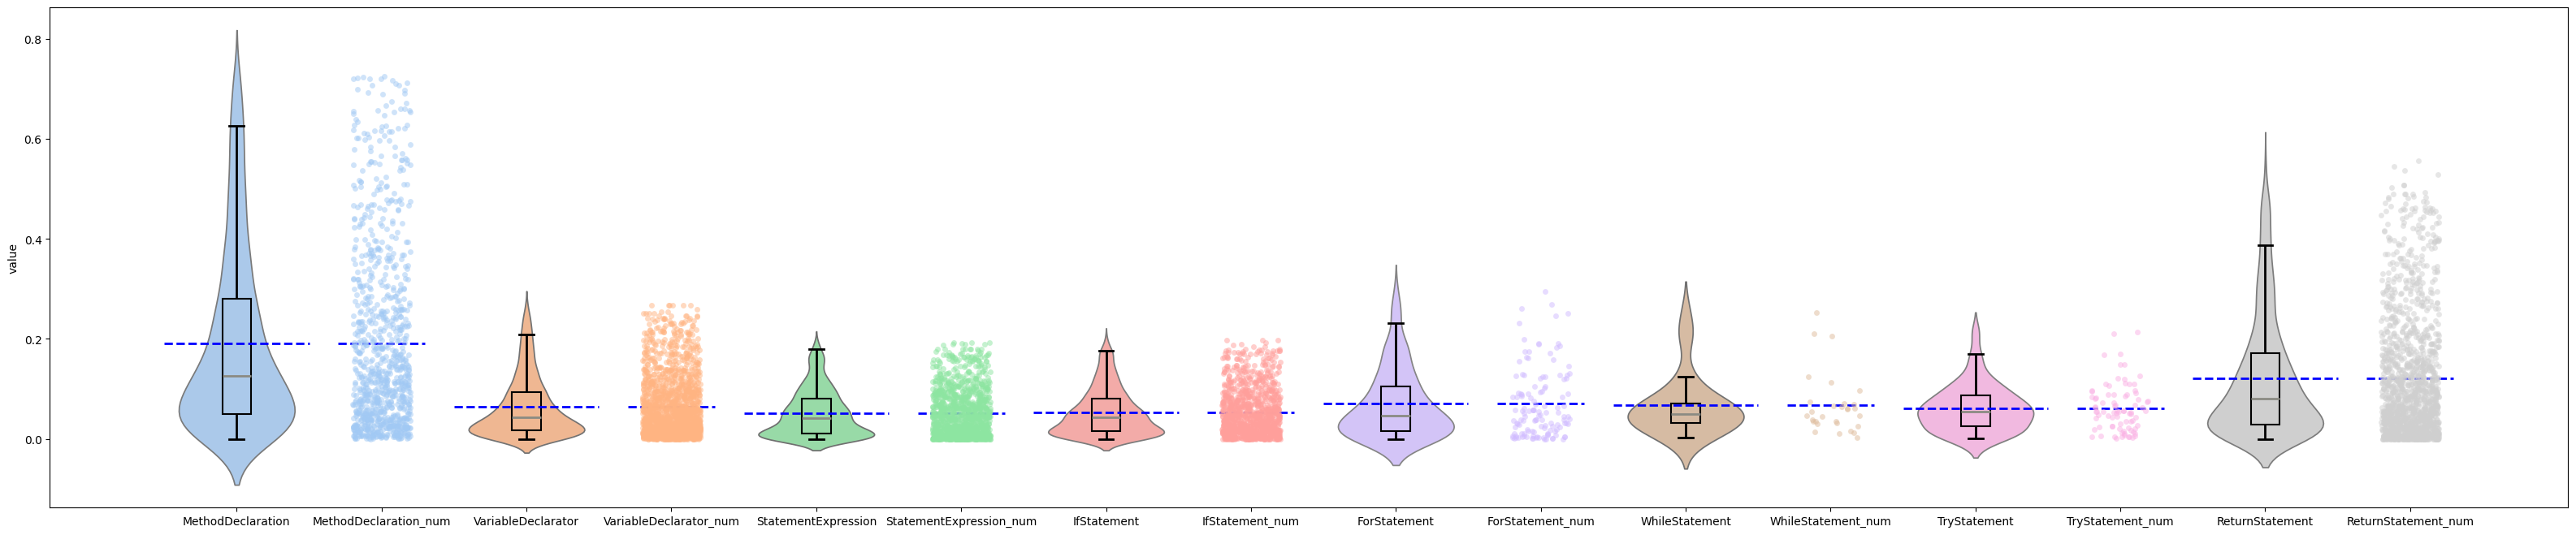

In [38]:
false_Winsorization_5_abs = false_Winsorization_5.abs()
get_paper_picture(false_Winsorization_5_abs,save_path='D:/BERT_learing/CCDP/picture/Winsorization_5%_false_Abs_ast.png')

In [39]:
false_for_iqr = filter_astlevel_attribution_false_df.copy()
false_iqr = iqr_outliers(false_for_iqr)

下四分位数: -0.151643144, 上四分位数: 0.149316957, 最小值下界: -0.6030832955000001, 最大值上界: 0.6007571085000001	此列删除数量152
下四分位数: -0.041262499999999994, 上四分位数: 0.060860995, 最小值下界: -0.19444774249999996, 最大值上界: 0.2140462375	此列删除数量260
下四分位数: -0.045833333, 上四分位数: 0.049, 最小值下界: -0.1880833325, 最大值上界: 0.1912499995	此列删除数量133
下四分位数: -0.038600464, 上四分位数: 0.05444814425, 最小值下界: -0.178173376375, 最大值上界: 0.194021056625	此列删除数量127
下四分位数: -0.029070833, 上四分位数: 0.06584999999999999, 最小值下界: -0.1714520825, 最大值上界: 0.2082312495	此列删除数量25
下四分位数: -0.05668674675, 上四分位数: 0.05851045325, 最小值下界: -0.22948254675000002, 最大值上界: 0.23130625324999998	此列删除数量3
下四分位数: -0.014922917, 上四分位数: 0.08800000000000001, 最小值下界: -0.1693072925, 最大值上界: 0.24238437550000003	此列删除数量8
下四分位数: -0.099910625, 上四分位数: 0.0950125, 最小值下界: -0.39229531250000005, 最大值上界: 0.3873971875	此列删除数量240
所有列的总共删除的数量: 948


均值 : 
MethodDeclaration      0.002966
VariableDeclarator     0.008986
StatementExpression    0.004695
IfStatement            0.007667
ForStatement           0.021109
WhileStatement         0.008632
TryStatement           0.033136
ReturnStatement       -0.001780
dtype: float64

从大到小排序后的均值 : 
TryStatement           0.033136
ForStatement           0.021109
VariableDeclarator     0.008986
WhileStatement         0.008632
IfStatement            0.007667
StatementExpression    0.004695
MethodDeclaration      0.002966
ReturnStatement       -0.001780
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/iqr_false_before_Abs_ast.png


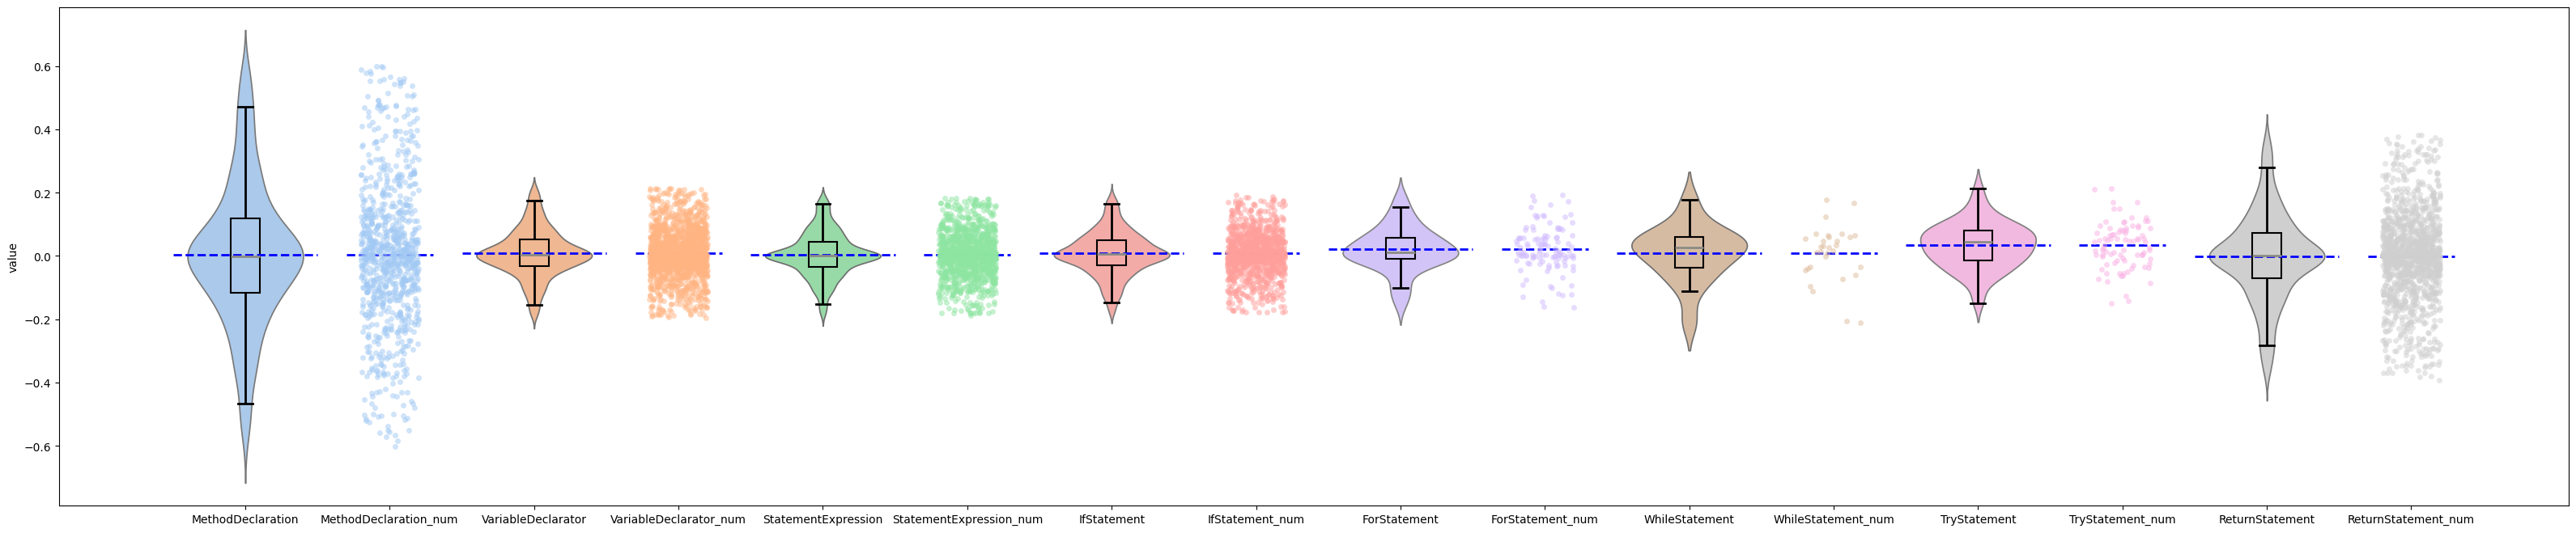

In [40]:
get_paper_picture(false_iqr,save_path='D:/BERT_learing/CCDP/picture/iqr_false_before_Abs_ast.png')

In [41]:
false_iqr_abs = false_iqr.abs()
false_iqr_abs.head()

MethodDeclaration  VariableDeclarator  StatementExpression  IfStatement  \
0           0.024898                 NaN             0.047608     0.106500   
1           0.180215            0.182800             0.047608     0.176867   
2                NaN                 NaN             0.134933     0.051950   
3           0.388700            0.003300             0.000000     0.101210   
4           0.167360            0.152411             0.164550     0.144325   

   ForStatement  WhileStatement  TryStatement  ReturnStatement  
0      0.101633        0.064745      0.054336         0.155400  
1      0.036594        0.096238      0.091388         0.061833  
2      0.000750        0.013096      0.210334         0.291900  
3           NaN        0.031400      0.004875              NaN  
4      0.052839        0.046905      0.013621              NaN

均值 : 
MethodDeclaration      0.167239
VariableDeclarator     0.056880
StatementExpression    0.051570
IfStatement            0.052625
ForStatement           0.055284
WhileStatement         0.067444
TryStatement           0.063710
ReturnStatement        0.101785
dtype: float64

从大到小排序后的均值 : 
MethodDeclaration      0.167239
ReturnStatement        0.101785
WhileStatement         0.067444
TryStatement           0.063710
VariableDeclarator     0.056880
ForStatement           0.055284
IfStatement            0.052625
StatementExpression    0.051570
dtype: float64
图像已保存为: D:/BERT_learing/CCDP/picture/iqr_false_Abs_ast.png


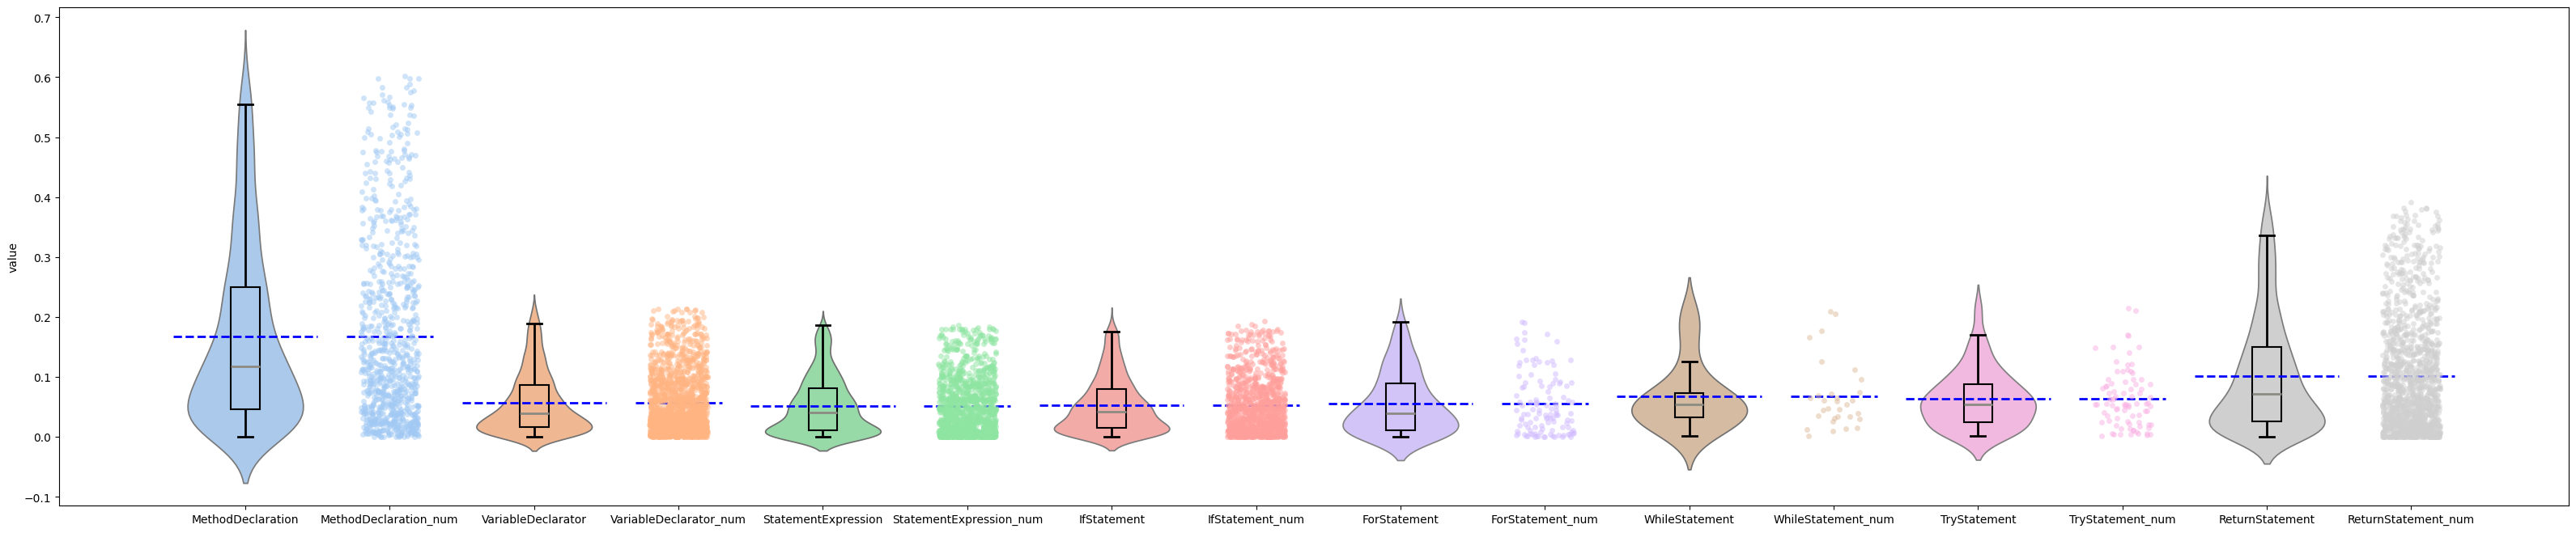

In [42]:
get_paper_picture(false_iqr_abs,save_path='D:/BERT_learing/CCDP/picture/iqr_false_Abs_ast.png')